This notebook is designed to demonstrate how to produce plots for airborne EM (line data) and induction (point data) on a vertical section. We compare AEM conductvitiy inversions from a 1D-inversion (stored as netcdf file produced using geophys_utils) and 3D-inversions (stored as asci xyx file).

Neil Symington neil.symington@ga.gov.au

In [6]:
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from geophys_utils._transect_utils import coords2distance
from hydrogeol_utils import SNMR_utils, AEM_utils, spatial_functions
import hydrogeol_utils.plotting_utils as plot_utils
import os, glob
import sqlalchemy as db
from sqlite3 import dbapi2 as sqlite

In [2]:
# First we will deomstrate some straight AEM plotting

# Open netcdf files

ncdir = r'\\prod.lan\active\proj\futurex\East_Kimberley\Data\Processed\Geophysics\AEM\OrdBonaparte_nbc_borehole_constrained\delivered_03_12_18\netcdf'

# Open the file with the EM measurements
# Here we use the data response file provided by Niel Christensen
EM_path = os.path.join(ncdir,'OrdBon2019_DataResp_cord2dLogKeep.nc')
EM_dataset = netCDF4.Dataset(EM_path)


# Open the file with the conductivity values
# The conductivity model was a 2d correlated borehole
# constrained inversion done by Niel Christensen

cond_path = os.path.join(ncdir,'OrdBon2019_ModelExp_cord2dLogKeep.nc')
cond_dataset = netCDF4.Dataset(cond_path)


In [19]:
# GRid the 3D inversion data from xyz file

indir = r"\\prod.lan\active\proj\futurex\East_Kimberley\Data\Processed\Geophysics\AEM\CGI_OB_3D_AEM_models\delivered\20190211\all_data"

os.chdir(indir)

CGI_gridded_data = {}

for file in glob.glob('*_xyzzc.txt'):
    
    line= int(file.split('_')[1][1:])
    
    CGI_conductivity = AEM_utils.parse_gridded_conductivity_file(infile, ['easting', 'northing', 'elevation_centre',
                                                           'elevation', 'conductivity'], null=1e-08)
    
    CGI_gridded_data[line] = AEM_utils.griddify_xyz(CGI_conductivity)
    
lines = list(CGI_gridded_data.keys())


In [21]:

list(lines)

[105401, 105501, 105901, 106001, 106101]

In [22]:
# Create an instance of plots for gridding the data
plots = plot_utils.ConductivitySectionPlot(cond_dataset, EM_dataset)

# Define some key variables which we want to inteprolate

plots.conductivity_variables = ['conductivity', 'data_residual', 'tx_height_measured', 'depth_of_investigation']

plots.EM_varibles  = ['data_values_by_low_moment_gate', 'data_values_by_high_moment_gate', 
                       'data_response_by_low_moment_gate', 'data_response_by_high_moment_gate']


# Define the resolution of th sections
xres, yres = 10., 3.

In [23]:
# Grid the line but leave it in memory
gridded_variables = plots.grid_variables(xres = xres, yres =yres, lines=list(lines), layer_subdivisions = 4,
                                          resampling_method = 'linear', save_hdf5 = False, return_dict = True)

In [35]:
def parse_misfit_files(lm_file, hm_file):
    
    hm_misfits = np.loadtxt(hm_file)

    lm_misfits = np.loadtxt(lm_file)
    
    # Dictionary for misfit data
    misfits = {}

    # Check that the coordinates are the same

    assert np.unique(hm_misfits[:,:2] == lm_misfits[:,:2])

    misfits['easting'] = hm_misfits[:,0]
    misfits['northing'] = hm_misfits[:,1]
    misfits['distance_along_line'] = coords2distance(hm_misfits[:,:2])
    misfits['hm_misfits'] = hm_misfits[:,2]
    misfits['lm_misfits'] = lm_misfits[:,2]

    # Calculate a normalised data misfit
    n_lmgates = EM_dataset.dimensions['low_moment_gate'].size
    n_hmgates = EM_dataset.dimensions['high_moment_gate'].size
    n_gates = n_lmgates + n_hmgates

    misfits['data_misfits'] = (n_lmgates/n_gates * misfits['lm_misfits']) + (n_hmgates/n_gates * misfits['hm_misfits'])
    
    return misfits
    

In [36]:
# Now bring in the data misfits from a separate file

CGI_misfits = {}

for hm_file in glob.glob('HM_output*'):
    lm_file = hm_file.replace('HM','LM')
    line = int(lm_file.split('_')[2].split('.')[0][1:])
    CGI_misfits[line] = parse_misfit_files(lm_file, hm_file)



In [38]:
# Bring in the induction data from spatialite database to pandas dataframe

DB_PATH = r"C:\temp\OrdBon_induction_gamma.sqlite"
        
engine = db.create_engine('sqlite:///' + DB_PATH, module=sqlite)

connection = engine.connect()

query = 'SELECT b.Bore_ID, b.X, b.Y, i.Depth, i.Conductivity FROM bore_header as b JOIN Induction as i on b.Bore_ID=I.Bore_ID;'

df_induction = pd.read_sql_query(query, connection)

print(df_induction)

        Bore_ID          X           Y    Depth  Conductivity
0       13BP01D  473886.62  8333260.73    2.355      0.067901
1       13BP01D  473886.62  8333260.73    2.365      0.065671
2       13BP01D  473886.62  8333260.73    2.375      0.063419
3       13BP01D  473886.62  8333260.73    2.385      0.061150
4       13BP01D  473886.62  8333260.73    2.395      0.058873
5       13BP01D  473886.62  8333260.73    2.405      0.056599
6       13BP01D  473886.62  8333260.73    2.415      0.054344
7       13BP01D  473886.62  8333260.73    2.425      0.052134
8       13BP01D  473886.62  8333260.73    2.435      0.049999
9       13BP01D  473886.62  8333260.73    2.445      0.048113
10      13BP01D  473886.62  8333260.73    2.455      0.046446
11      13BP01D  473886.62  8333260.73    2.465      0.044971
12      13BP01D  473886.62  8333260.73    2.475      0.043664
13      13BP01D  473886.62  8333260.73    2.485      0.042505
14      13BP01D  473886.62  8333260.73    2.495      0.041476
15      

In [39]:
# The induction data is far too dense for plotting so we resample

df_induction_resampled = pd.DataFrame(columns=['Bore_ID', 'X', 'Y', 'Depth', 'Conductivity'])

for item in df_induction['Bore_ID'].unique():
    mask= df_induction['Bore_ID'] == item
    # Create an array of resampled depths and values
    resampled_depth, resampled_vals = spatial_functions.resample_depth_data(df_induction[mask]['Depth'].values,
                                                    df_induction[mask]['Conductivity'].values,
                                                    resample_interval = 2.)
    
    df_resampled = pd.DataFrame({'Depth': resampled_depth,'Conductivity': resampled_vals})
    df_resampled['Bore_ID'] = item
    df_resampled['X'] = df_induction[mask]['X'].iloc[0]
    df_resampled['Y'] = df_induction[mask]['Y'].iloc[0]
    df_induction_resampled = df_induction_resampled.append(df_resampled)
    
    

C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


c:\users\u77932\documents\github\hydrogeol_utils\hydrogeol_utils\plotting_utils.py:997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['min_index'] = i


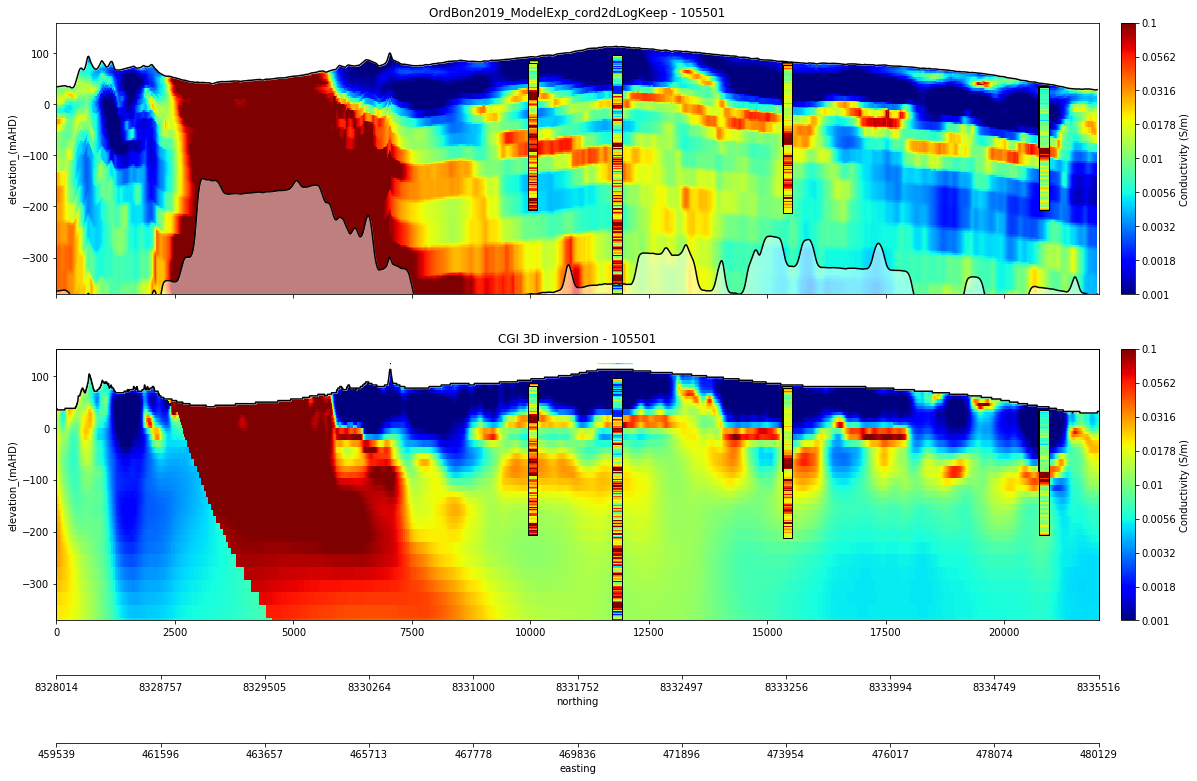

In [40]:

# Plot with linear stretch showing near surface
panel_settings = {'panel_1': {'variable': 'conductivity',
                             'plot_type': 'grid',
                             'panel_kwargs': {'title': 'AEM conductivity',
                                              'max_depth': 400, 'shade_doi': True, 'colourbar': True,
                                              'colourbar_label': 'Conductivity (S/m)',
                                             'log_plot': True, 'vmin': 0.001, 'vmax': 0.1,
                                             'cmap': 'jet', 'ylabel': 'elevation_(mAHD)'},
                             'height_ratio': 1},
                  
                 'panel_2': {'variable': 'conductivity',
                             'plot_type': 'grid',
                             'panel_kwargs': {'title': 'AEM conductivity',
                                              'max_depth': 400, 'shade_doi': False, 'colourbar': True,
                                              'colourbar_label': 'Conductivity (S/m)',
                                             'log_plot': True, 'vmin': 0.001, 'vmax': 0.1,
                                            'cmap': 'jet', 'ylabel': 'elevation_(mAHD)'},
                             'height_ratio': 1}}


plt.close()

fig, ax_array = plt.subplots(len(panel_settings), 1, figsize=(20, 11), sharex = True,
                                     gridspec_kw={'height_ratios':
                                                  plot_utils.unpack_plot_settings(panel_settings,'height_ratio')})

plot_utils.plot_grid(ax_array[0], gridded_variables[105501], 'conductivity',
                    plot_utils.unpack_plot_settings(panel_settings, "panel_kwargs")[0])

# We will only plot certain bores


plot_utils.plot_grid(ax_array[1], CGI_gridded_data[105501], 'conductivity',
                    plot_utils.unpack_plot_settings(panel_settings, "panel_kwargs")[1])


for bore in df_induction['Bore_ID'].unique():
    
    mask = (df_induction_resampled['Bore_ID'] == bore)

   
    for ax in ax_array:
        plot_utils.add_downhole_log_data(ax, df_induction_resampled[mask], gridded_variables[105501],
                                         'Conductivity', ['X','Y'], cmap='jet',
                                         colour_stretch=[0.001, 0.1], log_stretch = True, 
                                         max_distance=200., stick_thickness=200.)


    
ax_array[0].set_title("OrdBon2019_ModelExp_cord2dLogKeep - 105501")

ax_array[1].set_title("CGI 3D inversion - 105501")

ax_pos = plot_utils.align_axes(ax_array)

    # Add axis with northing at the bottom of the plot

plot_utils.add_axis_coords('northing', gridded_variables[105501]['northing'], ax_array[-1], ax_pos[1], offset=-0.2)

plot_utils.add_axis_coords('easting', gridded_variables[105501]['easting'], ax_array[-1], ax_pos[1], offset=-0.45)

#plt.savefig(r"C:\Temp\comparison_plot_105501-logstretch.png", dpi=300)

plt.show()

c:\users\u77932\documents\github\hydrogeol_utils\hydrogeol_utils\plotting_utils.py:997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['min_index'] = i


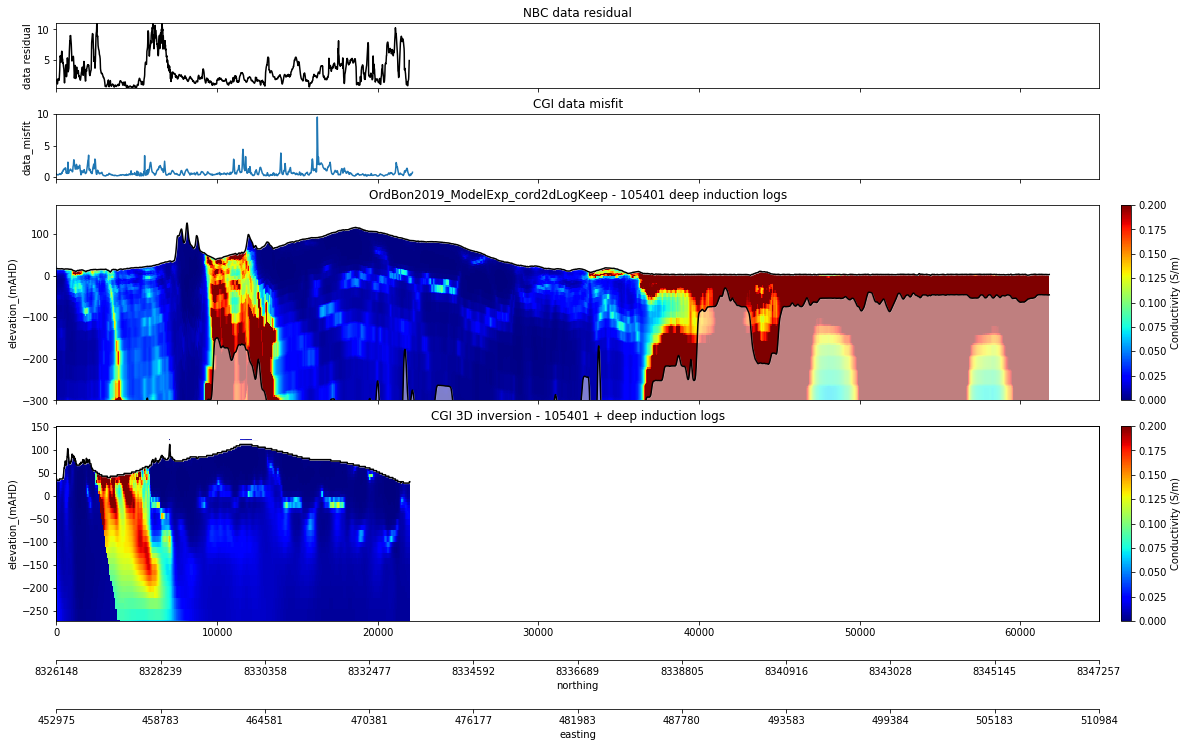

In [44]:
### Plot with linear stretch showing near surface
panel_settings = {'panel_1': {'panel_kwargs': {'title': 'NBC data residual', 'color': 'black',
                                              'ylabel': 'data residual',
                                              'legend': False},
                             'height_ratio': 1},
                  
                  'panel_2': {'panel_kwargs': {'title': 'CGI data residual', 'color': 'black',
                                              'ylabel': 'data residual',
                                              'legend': False},
                             'height_ratio': 1},
                  
                  'panel_3': {'variable': 'conductivity',
                             'plot_type': 'grid',
                             'panel_kwargs': {'title': 'AEM conductivity',
                                              'max_depth': 300, 'shade_doi': True, 'colourbar': True,
                                              'colourbar_label': 'Conductivity (S/m)',
                                             'log_plot': False, 'vmin': 0, 'vmax': 0.2,
                                             'cmap': 'jet', 'ylabel': 'elevation_(mAHD)'},
                             'height_ratio': 3},
                  
                 'panel_4': {'variable': 'conductivity',
                             'plot_type': 'grid',
                             'panel_kwargs': {'title': 'AEM conductivity',
                                              'max_depth': 300, 'shade_doi': False, 'colourbar': True,
                                              'colourbar_label': 'Conductivity (S/m)',
                                             'log_plot': False, 'vmin': 0, 'vmax': 0.2,
                                            'cmap': 'jet', 'ylabel': 'elevation_(mAHD)'},
                             'height_ratio': 3}}


plt.close()

for line in lines:

    fig, (ax_array) = plt.subplots(len(panel_settings), 1, figsize=(20, 11), sharex = True,
                                     gridspec_kw={'height_ratios':
                                                  plot_utils.unpack_plot_settings(panel_settings,'height_ratio')})

    plot_utils.plot_single_line(ax_array[0], gridded_variables[105501], 'data_residual',
                           plot_utils.unpack_plot_settings(panel_settings, "panel_kwargs")[0])

    ax_array[0].set_title('NBC data residual')

    ax_array[1].plot(CGI_misfits[line]['distance_along_line'], 
                     CGI_misfits[line]['data_misfits'])

    ax_array[1].set_ylabel('data_misfit')

    ax_array[1].set_title('CGI data misfit')

    plot_utils.plot_grid(ax_array[2], gridded_variables[line], 'conductivity',
                        plot_utils.unpack_plot_settings(panel_settings, "panel_kwargs")[2])

    # We will only plot certain bores


    plot_utils.plot_grid(ax_array[3], CGI_gridded_data[line], 'conductivity',
                        plot_utils.unpack_plot_settings(panel_settings, "panel_kwargs")[3])


    for bore in ['13BP01D', '18BP01D', '18BP07D', '18BP13D', 
                 'Bonaparte_2']:
    
        mask = (df_induction_resampled['Bore_ID'] == bore)
    
        for i in range(2,4):
            plot_utils.add_downhole_log_data(ax_array[i], df_induction_resampled[mask], gridded_variables[line],
                                     'Conductivity', ['X','Y'], cmap='jet',
                                     colour_stretch=[0, 0.2], log_stretch = False, 
                                         max_distance=200., stick_thickness=200.)


    
    ax_array[2].set_title("OrdBon2019_ModelExp_cord2dLogKeep - " + str(line) + " deep induction logs")

    ax_array[3].set_title("CGI 3D inversion - " + str(line) + " + deep induction logs")


    ax_pos = plot_utils.align_axes(ax_array)

    # Add axis with northing at the bottom of the plot

    plot_utils.add_axis_coords('northing', gridded_variables[line]['northing'], ax_array[-1], ax_pos[3], offset=-0.2)

    plot_utils.add_axis_coords('easting', gridded_variables[line]['easting'], ax_array[-1], ax_pos[3], offset=-0.45)

    #plt.savefig(r"C:\Temp\comparison_plot_105501.png", dpi=300)
    plt.show()
    
    break

In [ ]:
# Here we will run a quick and dirty fid point comparison for the CGI inversion

###TODO finish this extraction with perhaps a function for extracting a nearest neighbour
### conductivity profile


# A better approach might be to invert the borehole logs to obtain a conductivity
# model with an equivalent set of model layers as the AEM and then forward model the
# conductivity profile to get the equivalent AEM data
# This could be compared to the data generated by the 3D inversion for the nearest Tx location

# We need to get the induction data onto the same axes as the AEM

# Define the columns that are being interpolated 
parameter_columns = ['Conductivity']
interval_columns = ['Depth_from','Depth_to']

# Add a depth from and depth to column
df_induction['Depth_from'] = np.nan
df_induction['Depth_to'] = np.nan


for item in df_induction['Bore_ID'].unique():
    mask= df_induction['Bore_ID'] == item
    # Create a temporary dataframe
    df_temp = df_induction[mask]
    
    depth_from = df_temp['Depth']
    df_temp['Depth_from'] = depth_from
    
    depth_to = np.nan * np.zeros(len(df_temp), dtype=np.float)
    depth_to[:-1] = depth_from[1:]
    df_temp['Depth_to'] = depth_to
    
    df_induction.at[df_temp.index, interval_columns] = df_temp.loc[:, interval_columns]


# Create interpolated parameter columns in the conductivity dataframe
interpolated_columns = ['Conductivity_interpolated']
df_conductivity['Conductivity_interpolated'] = np.nan

# Define the new intervals

new_intervals = pd.DataFrame({'Depth_from': np.arange(0,500.,3),
                             'Depth_to': np.arange(3.,503.,3.)})

# Iterate through bores and interpolate them onto a new set of intervals     
for idx in df_induction['Bore_ID'].unique():
    # Define the new intervals based on the conductivity intervals
    mask= df_induction['Bore_ID'] == item
    # Extract the inversion data for the site
    df_ind = df_induction[mask]
    # Interpolate and add the interpolated parameter columns to the dataframe
    df_conductivity.at[new_intervals.index,
                       interpolated_columns] = spatial_functions.interpolate_layered_model(df_inv,
                                                               parameter_columns,
                                                               interval_columns,
                                                               new_intervals)[interpolated_columns]

# Now add X and Y based on a join with df_site

df_conductivity = df_conductivity.join(df_sites[['mid_X','mid_Y']], on = 'site_id')